**Week 10 - RNN - ORCL Closing stock price predictor**

In this notebook, we use the closing prices of the past nine days to predict the 10-day closing stock price of Oracle Corporation(ORCL). RNN, LTSM, Gru, and Conv1D techniques are being used to predict the 10th-day closing price.

Datasource: The data has been downloaded from daily stock prices using Yahoo Finance.
https://finance.yahoo.com/quote/ORCL/history?p=ORCL

In [174]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [175]:
import pandas as pd

oracle = pd.read_csv('ORCL.csv')

oracle.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-25,76.199997,77.059998,74.699997,76.980003,75.643715,7305900
1,2022-04-26,76.349998,76.650002,74.480003,74.510002,73.216583,7555200
2,2022-04-27,74.580002,76.019997,74.419998,74.760002,73.462250,7279200
3,2022-04-28,75.519997,76.629997,74.599998,76.139999,74.818291,6177900
4,2022-04-29,75.339996,75.870003,73.150002,73.400002,72.125854,7946900


## Create dataframe to store results    

We are running different models in this notebook. We will store the results in a dataframe for easy comparison.

In [176]:
df_results = pd.DataFrame({'model': [], 'time': [], 'mse': []})

In [177]:
#Drop the columns we don't need

oracle = oracle.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)

In [178]:
oracle

,Date,Close
0,2022-04-25,76.980003
1,2022-04-26,74.510002
2,2022-04-27,74.760002
3,2022-04-28,76.139999
4,2022-04-29,73.400002
...,...,...
245,2023-04-17,95.589996
246,2023-04-18,96.470001
247,2023-04-19,95.809998
248,2023-04-20,94.830002


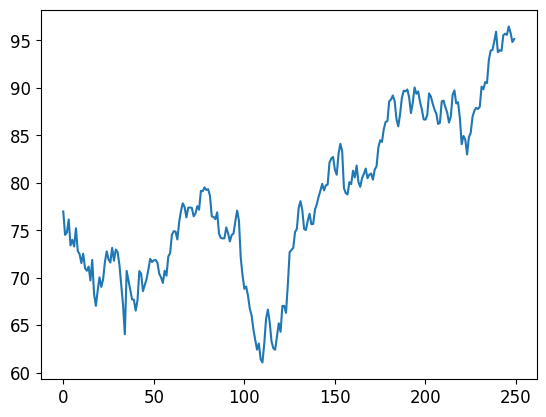

In [179]:
#Plot Closing Value

plt.plot(oracle['Close'])
plt.show()

In [180]:
oracle.shape

(250, 2)

There is a total of 250 Days

In [181]:
# Re-organize the data set by 10 days

temp = np.array(oracle['Close']).reshape(25,10)

temp

array([[76.980003, 74.510002, 74.760002, 76.139999, 73.400002, 74.      ,
        73.290001, 75.209999, 72.800003, 72.489998],
       [71.540001, 72.529999, 71.029999, 70.730003, 71.169998, 69.709999,
        71.879997, 68.300003, 67.040001, 68.629997],
       [70.040001, 69.029999, 69.830002, 71.660004, 72.779999, 71.919998,
        71.599998, 73.139999, 71.790001, 72.970001],
       [72.690002, 71.379997, 69.220001, 67.139999, 64.050003, 70.720001,
        69.699997, 68.709999, 67.720001, 67.68    ],
       [66.529999, 67.629997, 70.699997, 70.410004, 68.580002, 69.209999,
        69.870003, 70.870003, 71.989998, 71.660004],
       [71.830002, 71.870003, 71.57    , 70.410004, 70.029999, 69.449997,
        70.739998, 70.209999, 72.239998, 72.589996],
       [74.540001, 74.900002, 74.860001, 74.029999, 75.870003, 77.040001,
        77.839996, 77.440002, 76.349998, 77.370003],
       [77.400002, 77.349998, 76.470001, 76.769997, 77.540001, 77.160004,
        79.150002, 79.110001, 79.5199

In [182]:
# Convert to dataframe

temp_df = pd.DataFrame(temp, columns=np.arange(0,10,1))

temp_df

,0,1,2,3,4,5,6,7,8,9
0,76.980003,74.510002,74.760002,76.139999,73.400002,74.000000,73.290001,75.209999,72.800003,72.489998
1,71.540001,72.529999,71.029999,70.730003,71.169998,69.709999,71.879997,68.300003,67.040001,68.629997
2,70.040001,69.029999,69.830002,71.660004,72.779999,71.919998,71.599998,73.139999,71.790001,72.970001
3,72.690002,71.379997,69.220001,67.139999,64.050003,70.720001,69.699997,68.709999,67.720001,67.680000
4,66.529999,67.629997,70.699997,70.410004,68.580002,69.209999,69.870003,70.870003,71.989998,71.660004
5,71.830002,71.870003,71.570000,70.410004,70.029999,69.449997,70.739998,70.209999,72.239998,72.589996
6,74.540001,74.900002,74.860001,74.029999,75.870003,77.040001,77.839996,77.440002,76.349998,77.370003
7,77.400002,77.349998,76.470001,76.769997,77.540001,77.160004,79.150002,79.110001,79.519997,79.250000
8,79.320000,78.660004,76.459999,76.410004,76.169998,76.889999,74.650002,74.190002,74.139999,74.150002
9,75.300003,74.680000,73.830002,74.489998,74.650002,75.910004,77.080002,76.040001,72.120003,70.239998


# Reshape for Standardizing Data

In [183]:
# Let's create a single sequence (i.e., feature) for standardization

temp_1feature = np.array(temp_df).ravel().reshape(-1,1)

temp_1feature.shape

(250, 1)

In [184]:
temp_1feature

array([[76.980003],
       [74.510002],
       [74.760002],
       [76.139999],
       [73.400002],
       [74.      ],
       [73.290001],
       [75.209999],
       [72.800003],
       [72.489998],
       [71.540001],
       [72.529999],
       [71.029999],
       [70.730003],
       [71.169998],
       [69.709999],
       [71.879997],
       [68.300003],
       [67.040001],
       [68.629997],
       [70.040001],
       [69.029999],
       [69.830002],
       [71.660004],
       [72.779999],
       [71.919998],
       [71.599998],
       [73.139999],
       [71.790001],
       [72.970001],
       [72.690002],
       [71.379997],
       [69.220001],
       [67.139999],
       [64.050003],
       [70.720001],
       [69.699997],
       [68.709999],
       [67.720001],
       [67.68    ],
       [66.529999],
       [67.629997],
       [70.699997],
       [70.410004],
       [68.580002],
       [69.209999],
       [69.870003],
       [70.870003],
       [71.989998],
       [71.660004],


## Standardize the values

In [185]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

temp_std = scaler.fit_transform(temp_1feature)

## Reshape the data back to 10 Day format

In [186]:
temp_reshaped = temp_std.reshape(25,10)

temp_reshaped.shape

(25, 10)

In [187]:
#Pandas version of the reshaped data

pd.DataFrame(temp_reshaped, columns=np.arange(0,10,1))

,0,1,2,3,4,5,6,7,8,9
0,-0.152523,-0.440139,-0.411028,-0.250336,-0.569392,-0.499526,-0.582201,-0.358629,-0.639258,-0.675356
1,-0.785978,-0.670699,-0.845364,-0.880297,-0.829062,-0.999070,-0.746387,-1.163256,-1.309976,-1.124830
2,-0.960644,-1.078252,-0.985097,-0.772004,-0.641588,-0.741730,-0.778992,-0.599668,-0.756867,-0.619463
3,-0.652067,-0.804609,-1.056128,-1.298331,-1.658143,-0.881462,-1.000235,-1.115514,-1.230794,-1.235452
4,-1.369362,-1.241274,-0.883791,-0.917559,-1.130652,-1.057292,-0.980439,-0.863995,-0.733578,-0.772004
5,-0.752209,-0.747551,-0.782485,-0.917559,-0.961808,-1.029346,-0.879133,-0.940849,-0.704467,-0.663712
6,-0.436646,-0.394726,-0.399384,-0.496033,-0.281775,-0.145536,-0.052382,-0.098959,-0.225883,-0.107109
7,-0.103616,-0.109439,-0.211909,-0.176977,-0.087314,-0.131563,0.100161,0.095503,0.143244,0.111805
8,0.119956,0.043103,-0.213074,-0.218896,-0.246843,-0.163003,-0.423837,-0.477401,-0.483224,-0.482059
9,-0.348148,-0.420344,-0.519321,-0.442469,-0.423837,-0.277117,-0.140878,-0.261980,-0.718440,-0.937355


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of daily temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are using a random split because each day as an independent sample.

In [188]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(temp_reshaped, test_size=0.3)

# if we neede to maintain the ordering of the data, we can use the following code to split the data
#split_point = int(len(temp_reshaped)*0.7)
#train, test = temp_reshaped[:split_point], temp_reshaped[split_point:]

In [189]:
train.shape

(17, 10)

In [190]:
train

array([[ 0.67306458,  0.77320636,  0.73012187,  0.54614103,  0.76039753,
         0.81163309,  1.00958744,  1.08178303,  1.11904509,  1.10507147],
       [-0.75220899, -0.74755112, -0.78248465, -0.91755915, -0.96180843,
        -1.02934615, -0.87913335, -0.94084852, -0.70446744, -0.6637123 ],
       [-0.96064376, -1.07825237, -0.98509687, -0.77200423, -0.6415876 ,
        -0.7417295 , -0.77899157, -0.59966778, -0.75686687, -0.61946302],
       [-1.62786787, -1.31230492, -1.31114025, -1.39614385, -1.05263459,
        -0.65090335, -0.62528557, -0.59966778, -0.40404185, -0.36561512],
       [ 0.3609947 ,  0.29811486,  0.55196276,  0.67772245,  0.58922471,
         0.1327647 ,  0.07221432,  0.05707603,  0.20728882,  0.18283571],
       [-0.65206721, -0.80460935, -1.05612779, -1.29833141, -1.65814272,
        -0.88146188, -1.00023516, -1.11551443, -1.2307937 , -1.23545157],
       [-1.36936221, -1.24127412, -0.88379123, -0.91755915, -1.13065179,
        -1.05729246, -0.980439  , -0.86399506

In [191]:
train[0]

array([0.67306458, 0.77320636, 0.73012187, 0.54614103, 0.76039753,
       0.81163309, 1.00958744, 1.08178303, 1.11904509, 1.10507147])

In [192]:
test.shape

(8, 10)

In [193]:
test[0]

array([ 0.11995587,  0.04310334, -0.21307391, -0.21889552, -0.24684277,
       -0.16300302, -0.42383709, -0.4774013 , -0.48322385, -0.48205906])

# Create Input and Target values

The first 9 Days will be input to predict the 10th Day reading (i.e., target)

In [194]:
# The first 9 columns (from 0 to 8) are inputs

train_inputs = train[:,:-1] # same as train_inputs = train[:,:9]


pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,0.673065,0.773206,0.730122,0.546141,0.760398,0.811633,1.009587,1.081783,1.119045
1,-0.752209,-0.747551,-0.782485,-0.917559,-0.961808,-1.029346,-0.879133,-0.940849,-0.704467
2,-0.960644,-1.078252,-0.985097,-0.772004,-0.641588,-0.741730,-0.778992,-0.599668,-0.756867
3,-1.627868,-1.312305,-1.311140,-1.396144,-1.052635,-0.650903,-0.625286,-0.599668,-0.404042
4,0.360995,0.298115,0.551963,0.677722,0.589225,0.132765,0.072214,0.057076,0.207289
5,-0.652067,-0.804609,-1.056128,-1.298331,-1.658143,-0.881462,-1.000235,-1.115514,-1.230794
6,-1.369362,-1.241274,-0.883791,-0.917559,-1.130652,-1.057292,-0.980439,-0.863995,-0.733578
7,0.973490,1.030547,1.296039,1.257613,1.170280,1.098085,1.046850,0.921090,0.935063
8,0.313253,0.237564,0.362159,0.401750,0.632309,0.720807,0.701011,0.858211,0.946708
9,1.207543,1.126031,1.060823,0.937392,1.010752,1.276244,1.333301,1.172609,1.187747


## Add one more dimension to make it ready for RNNs

In [195]:
train_inputs

array([[ 0.67306458,  0.77320636,  0.73012187,  0.54614103,  0.76039753,
         0.81163309,  1.00958744,  1.08178303,  1.11904509],
       [-0.75220899, -0.74755112, -0.78248465, -0.91755915, -0.96180843,
        -1.02934615, -0.87913335, -0.94084852, -0.70446744],
       [-0.96064376, -1.07825237, -0.98509687, -0.77200423, -0.6415876 ,
        -0.7417295 , -0.77899157, -0.59966778, -0.75686687],
       [-1.62786787, -1.31230492, -1.31114025, -1.39614385, -1.05263459,
        -0.65090335, -0.62528557, -0.59966778, -0.40404185],
       [ 0.3609947 ,  0.29811486,  0.55196276,  0.67772245,  0.58922471,
         0.1327647 ,  0.07221432,  0.05707603,  0.20728882],
       [-0.65206721, -0.80460935, -1.05612779, -1.29833141, -1.65814272,
        -0.88146188, -1.00023516, -1.11551443, -1.2307937 ],
       [-1.36936221, -1.24127412, -0.88379123, -0.91755915, -1.13065179,
        -1.05729246, -0.980439  , -0.86399506, -0.73357843],
       [ 0.97349017,  1.03054735,  1.29603941,  1.25761268,  1

In [196]:
train_inputs.shape 

(17, 9)

In [197]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(17, 9, 1)

In [198]:
train_x

array([[[ 0.67306458],
        [ 0.77320636],
        [ 0.73012187],
        [ 0.54614103],
        [ 0.76039753],
        [ 0.81163309],
        [ 1.00958744],
        [ 1.08178303],
        [ 1.11904509]],

       [[-0.75220899],
        [-0.74755112],
        [-0.78248465],
        [-0.91755915],
        [-0.96180843],
        [-1.02934615],
        [-0.87913335],
        [-0.94084852],
        [-0.70446744]],

       [[-0.96064376],
        [-1.07825237],
        [-0.98509687],
        [-0.77200423],
        [-0.6415876 ],
        [-0.7417295 ],
        [-0.77899157],
        [-0.59966778],
        [-0.75686687]],

       [[-1.62786787],
        [-1.31230492],
        [-1.31114025],
        [-1.39614385],
        [-1.05263459],
        [-0.65090335],
        [-0.62528557],
        [-0.59966778],
        [-0.40404185]],

       [[ 0.3609947 ],
        [ 0.29811486],
        [ 0.55196276],
        [ 0.67772245],
        [ 0.58922471],
        [ 0.1327647 ],
        [ 0.07221432],
   

In [199]:
# The last column (9) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,1.105071
1,-0.663712
2,-0.619463
3,-0.365615
4,0.182836
5,-1.235452
6,-0.772004
7,1.198227
8,0.956023
9,0.999108


#Repeat that for test

In [200]:
test.shape

(8, 10)

In [201]:
# The first 9 columns (from 0 to 8) are inputs

test_inputs = test[:,:9]

In [202]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(8, 9, 1)

In [203]:
# The last column (9) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,-0.482059
1,0.298115
2,-0.675356
3,2.052925
4,-1.524233
5,-0.937355
6,-0.130399
7,-1.124830


# A normal (cross-sectional) NN

This model assumes that the data is NOT a time-series data set. It treats the data as cross-sectional and the columns being independent of each other.

In [204]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[9, 1]),
    keras.layers.Dense(9, activation='relu'),
    keras.layers.Dense(1, activation=None)
    
])

model.compile(loss="mse", optimizer='Adam')

import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_x, train_target, epochs=100, callbacks=[call_back])

end_time = time.time()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.3866

1/1 [==============================] - 1s 573ms/step - loss: 0.3866
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.3694

1/1 [==============================] - 0s 21ms/step - loss: 0.3694
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.3528

1/1 [==============================] - 0s 15ms/step - loss: 0.3528
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.3371

1/1 [==============================] - 0s 15ms/step - loss: 0.3371
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.3219

1/1 [==============================] - 0s 19ms/step - loss: 0.3219
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.3073

1/1 [==============================] - 0s 19ms/step - loss: 0.3073
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.2934

1/1 [==============================] - 0s 13ms/step - loss: 0.2934
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.2801

1/1 [==============================] - 0s 15ms/step - loss: 0.2801
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.2675

1/1 [==============================] - 0s 13ms/step - loss: 0.2675
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.2554

1/1 [==============================] - 0s 14ms/step - loss: 0.2554
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.2439

1/1 [==============================] - 0s 13ms/step - loss: 0.2439
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.2331

1/1 [==============================] - 0s 11ms/step - loss: 0.2331
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.2228

1/1 [==============================] - 0s 14ms/step - loss: 0.2228
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.2131

1/1 [==============================] - 0s 14ms/step - loss: 0.2131
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.2039

1/1 [==============================] - 0s 14ms/step - loss: 0.2039
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.1953

1/1 [==============================] - 0s 17ms/step - loss: 0.1953
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.1871

1/1 [==============================] - 0s 15ms/step - loss: 0.1871
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.1794

1/1 [==============================] - 0s 9ms/step - loss: 0.1794
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.1722

1/1 [==============================] - 0s 13ms/step - loss: 0.1722
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.1654

1/1 [==============================] - 0s 11ms/step - loss: 0.1654
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.1590

1/1 [==============================] - 0s 10ms/step - loss: 0.1590
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.1529

1/1 [==============================] - 0s 14ms/step - loss: 0.1529
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.1472

1/1 [==============================] - 0s 16ms/step - loss: 0.1472
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.1417

1/1 [==============================] - 0s 9ms/step - loss: 0.1417
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.1366

1/1 [==============================] - 0s 13ms/step - loss: 0.1366
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.1316

1/1 [==============================] - 0s 9ms/step - loss: 0.1316
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.1270

1/1 [==============================] - 0s 14ms/step - loss: 0.1270
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.1225

1/1 [==============================] - 0s 9ms/step - loss: 0.1225
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1183

1/1 [==============================] - 0s 14ms/step - loss: 0.1183
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1142

1/1 [==============================] - 0s 9ms/step - loss: 0.1142
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1103

1/1 [==============================] - 0s 19ms/step - loss: 0.1103
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.1065

1/1 [==============================] - 0s 19ms/step - loss: 0.1065
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.1027

1/1 [==============================] - 0s 9ms/step - loss: 0.1027
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.0990

1/1 [==============================] - 0s 11ms/step - loss: 0.0990
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.0956

1/1 [==============================] - 0s 9ms/step - loss: 0.0956
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0923

1/1 [==============================] - 0s 12ms/step - loss: 0.0923
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.0893

1/1 [==============================] - 0s 24ms/step - loss: 0.0893
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0865

1/1 [==============================] - 0s 16ms/step - loss: 0.0865
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0839

1/1 [==============================] - 0s 12ms/step - loss: 0.0839
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0815

1/1 [==============================] - 0s 12ms/step - loss: 0.0815
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0792

1/1 [==============================] - 0s 11ms/step - loss: 0.0792
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0772

1/1 [==============================] - 0s 16ms/step - loss: 0.0772
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0753

1/1 [==============================] - 0s 11ms/step - loss: 0.0753
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0735

1/1 [==============================] - 0s 18ms/step - loss: 0.0735
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0719

1/1 [==============================] - 0s 13ms/step - loss: 0.0719
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0704

1/1 [==============================] - 0s 14ms/step - loss: 0.0704
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0691

1/1 [==============================] - 0s 10ms/step - loss: 0.0691
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0679

1/1 [==============================] - 0s 12ms/step - loss: 0.0679
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0668

1/1 [==============================] - 0s 15ms/step - loss: 0.0668
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0657

1/1 [==============================] - 0s 11ms/step - loss: 0.0657
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0648

1/1 [==============================] - 0s 15ms/step - loss: 0.0648
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0639

1/1 [==============================] - 0s 10ms/step - loss: 0.0639
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0631

1/1 [==============================] - 0s 18ms/step - loss: 0.0631
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0623

1/1 [==============================] - 0s 16ms/step - loss: 0.0623
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0616

1/1 [==============================] - 0s 11ms/step - loss: 0.0616
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0609

1/1 [==============================] - 0s 11ms/step - loss: 0.0609
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0602

1/1 [==============================] - 0s 15ms/step - loss: 0.0602
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0596

1/1 [==============================] - 0s 10ms/step - loss: 0.0596
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0590

1/1 [==============================] - 0s 21ms/step - loss: 0.0590
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0585

1/1 [==============================] - 0s 53ms/step - loss: 0.0585
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0579

1/1 [==============================] - 0s 11ms/step - loss: 0.0579
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0574

1/1 [==============================] - 0s 11ms/step - loss: 0.0574
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0569

1/1 [==============================] - 0s 11ms/step - loss: 0.0569
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0563

1/1 [==============================] - 0s 12ms/step - loss: 0.0563
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0558

1/1 [==============================] - 0s 10ms/step - loss: 0.0558
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0553

1/1 [==============================] - 0s 17ms/step - loss: 0.0553
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0547

1/1 [==============================] - 0s 11ms/step - loss: 0.0547
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0542

1/1 [==============================] - 0s 14ms/step - loss: 0.0542
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0537

1/1 [==============================] - 0s 13ms/step - loss: 0.0537
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0532

1/1 [==============================] - 0s 8ms/step - loss: 0.0532
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0527

1/1 [==============================] - 0s 13ms/step - loss: 0.0527
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0522

1/1 [==============================] - 0s 8ms/step - loss: 0.0522
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0517

1/1 [==============================] - 0s 8ms/step - loss: 0.0517
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0512

1/1 [==============================] - 0s 12ms/step - loss: 0.0512
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0507

1/1 [==============================] - 0s 8ms/step - loss: 0.0507
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0502

1/1 [==============================] - 0s 8ms/step - loss: 0.0502
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0498

1/1 [==============================] - 0s 9ms/step - loss: 0.0498
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0493

1/1 [==============================] - 0s 10ms/step - loss: 0.0493
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0488

1/1 [==============================] - 0s 12ms/step - loss: 0.0488
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0484

1/1 [==============================] - 0s 20ms/step - loss: 0.0484
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0479

1/1 [==============================] - 0s 16ms/step - loss: 0.0479
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0475

1/1 [==============================] - 0s 9ms/step - loss: 0.0475
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0471

1/1 [==============================] - 0s 18ms/step - loss: 0.0471
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0466

1/1 [==============================] - 0s 14ms/step - loss: 0.0466
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0462

1/1 [==============================] - 0s 15ms/step - loss: 0.0462
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0458

1/1 [==============================] - 0s 10ms/step - loss: 0.0458
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0454

1/1 [==============================] - 0s 8ms/step - loss: 0.0454
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0450

1/1 [==============================] - 0s 8ms/step - loss: 0.0450
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0446

1/1 [==============================] - 0s 10ms/step - loss: 0.0446
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0442

1/1 [==============================] - 0s 9ms/step - loss: 0.0442
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0438

1/1 [==============================] - 0s 9ms/step - loss: 0.0438
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0434

1/1 [==============================] - 0s 12ms/step - loss: 0.0434
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0430

1/1 [==============================] - 0s 8ms/step - loss: 0.0430
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0426

1/1 [==============================] - 0s 11ms/step - loss: 0.0426
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0422

1/1 [==============================] - 0s 8ms/step - loss: 0.0422
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0418

1/1 [==============================] - 0s 8ms/step - loss: 0.0418
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0414

1/1 [==============================] - 0s 8ms/step - loss: 0.0414
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0411

1/1 [==============================] - 0s 11ms/step - loss: 0.0411
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0407

1/1 [==============================] - 0s 12ms/step - loss: 0.0407
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0403

1/1 [==============================] - 0s 7ms/step - loss: 0.0403


Predictions

In [205]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 86ms/step


In [206]:
# Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [207]:
comparison

,actual,predicted
0,74.150002,75.455063
1,80.849998,81.261299
2,72.489998,73.312164
3,95.919998,93.600098
4,65.199997,63.871067
5,70.239998,75.962509
6,77.169998,75.656334
7,68.629997,70.869377


In [208]:
mse_score = mean_squared_error(comparison['actual'], comparison['predicted'])

In [209]:
df_result = pd.DataFrame(
    {
        'model': ['NN'], 
        'time': [end_time - start_time],
        'mse': [mse_score]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

In [210]:
df_results

,model,time,mse
0,NN,2.250607,6.21868


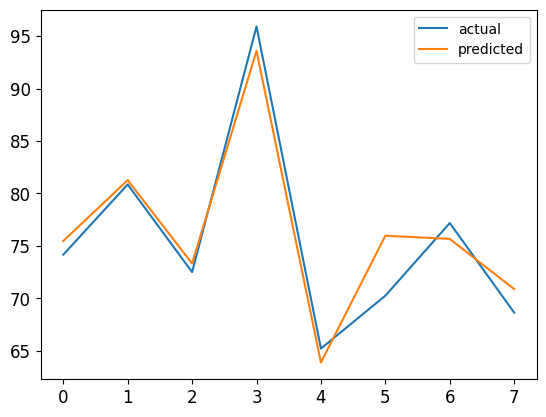

In [211]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

### How to interpret the output shape?

* The first layer
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * 9 is the number of units in the layer, since there will be 9 outputs from this layer, the second dimension will have 9
* The second layer
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network. This will be the same at each later, since the batch size is the same during each epoch.
  * 9 is the number of units in the layer, since there will be 9 outputs from these 9 units
* The third layer
  * None is a wild-card, is the number of observations given in the batch.
  * 1 is the number of units in the layer. Since the output is a numerical value, there is one unit for the output, and therefore 1 is the number of outputs.


We can write this formulaically as:

In [212]:
p = 1  # for NN, one weight per unit input
b = 1  # for NN, one bias per unit

# First hidden layer
i = 9 # 36 inputs from the previous layer (flatten layer)
h = 9 # number of units in this layer 

p * (h*i + b*h)

90

## Simple RNN with more layers

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training. However, if the output of RNN is sent to a DENSE layer, then a single value should be sent. That's why there is no "return sequences" right before DENSE layers.**

In [213]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [214]:
model.compile(loss="mse", optimizer='Adam')

import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_x, train_target, epochs=100, callbacks=[call_back])

end_time = time.time()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.9041

1/1 [==============================] - 2s 2s/step - loss: 0.9041
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.8322

1/1 [==============================] - 0s 19ms/step - loss: 0.8322
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.7869

1/1 [==============================] - 0s 17ms/step - loss: 0.7869
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.7547

1/1 [==============================] - 0s 19ms/step - loss: 0.7547
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.7200

1/1 [==============================] - 0s 18ms/step - loss: 0.7200
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.6816

1/1 [==============================] - 0s 16ms/step - loss: 0.6816
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.6441

1/1 [==============================] - 0s 18ms/step - loss: 0.6441
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.6129

1/1 [==============================] - 0s 15ms/step - loss: 0.6129
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.5847

1/1 [==============================] - 0s 17ms/step - loss: 0.5847
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.5585

1/1 [==============================] - 0s 18ms/step - loss: 0.5585
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.5320

1/1 [==============================] - 0s 17ms/step - loss: 0.5320
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.5043

1/1 [==============================] - 0s 15ms/step - loss: 0.5043
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.4773

1/1 [==============================] - 0s 19ms/step - loss: 0.4773
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.4506

1/1 [==============================] - 0s 16ms/step - loss: 0.4506
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.4233

1/1 [==============================] - 0s 20ms/step - loss: 0.4233
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.3930

1/1 [==============================] - 0s 15ms/step - loss: 0.3930
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.3600

1/1 [==============================] - 0s 16ms/step - loss: 0.3600
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.3240

1/1 [==============================] - 0s 18ms/step - loss: 0.3240
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.2855

1/1 [==============================] - 0s 16ms/step - loss: 0.2855
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.2478

1/1 [==============================] - 0s 14ms/step - loss: 0.2478
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.2123

1/1 [==============================] - 0s 20ms/step - loss: 0.2123
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.1794

1/1 [==============================] - 0s 19ms/step - loss: 0.1794
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.1495

1/1 [==============================] - 0s 19ms/step - loss: 0.1495
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.1220

1/1 [==============================] - 0s 16ms/step - loss: 0.1220
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.0969

1/1 [==============================] - 0s 17ms/step - loss: 0.0969
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.0747

1/1 [==============================] - 0s 19ms/step - loss: 0.0747
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.0555

1/1 [==============================] - 0s 21ms/step - loss: 0.0555
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.0406

1/1 [==============================] - 0s 17ms/step - loss: 0.0406
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.0303

1/1 [==============================] - 0s 18ms/step - loss: 0.0303
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.0238

1/1 [==============================] - 0s 25ms/step - loss: 0.0238
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.0208

1/1 [==============================] - 0s 20ms/step - loss: 0.0208
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.0212

1/1 [==============================] - 0s 27ms/step - loss: 0.0212
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.0248

1/1 [==============================] - 0s 27ms/step - loss: 0.0248
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.0301

1/1 [==============================] - 0s 22ms/step - loss: 0.0301
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.0353

1/1 [==============================] - 0s 25ms/step - loss: 0.0353
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0385

1/1 [==============================] - 0s 29ms/step - loss: 0.0385
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.0391

1/1 [==============================] - 0s 21ms/step - loss: 0.0391
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0375

1/1 [==============================] - 0s 22ms/step - loss: 0.0375
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0341

1/1 [==============================] - 0s 20ms/step - loss: 0.0341
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0297

1/1 [==============================] - 0s 23ms/step - loss: 0.0297
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0251

1/1 [==============================] - 0s 25ms/step - loss: 0.0251
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0209

1/1 [==============================] - 0s 19ms/step - loss: 0.0209
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 23ms/step - loss: 0.0177
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0157

1/1 [==============================] - 0s 19ms/step - loss: 0.0157
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0148

1/1 [==============================] - 0s 20ms/step - loss: 0.0148
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0146

1/1 [==============================] - 0s 23ms/step - loss: 0.0146
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0150

1/1 [==============================] - 0s 21ms/step - loss: 0.0150
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0155

1/1 [==============================] - 0s 18ms/step - loss: 0.0155
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0161

1/1 [==============================] - 0s 19ms/step - loss: 0.0161
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0167

1/1 [==============================] - 0s 20ms/step - loss: 0.0167
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0171

1/1 [==============================] - 0s 21ms/step - loss: 0.0171
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0171

1/1 [==============================] - 0s 27ms/step - loss: 0.0171
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0169

1/1 [==============================] - 0s 19ms/step - loss: 0.0169
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0164

1/1 [==============================] - 0s 26ms/step - loss: 0.0164
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0158

1/1 [==============================] - 0s 28ms/step - loss: 0.0158
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0150

1/1 [==============================] - 0s 33ms/step - loss: 0.0150
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0143

1/1 [==============================] - 0s 28ms/step - loss: 0.0143
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0135

1/1 [==============================] - 0s 24ms/step - loss: 0.0135
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0129

1/1 [==============================] - 0s 28ms/step - loss: 0.0129
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0124

1/1 [==============================] - 0s 25ms/step - loss: 0.0124
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0121

1/1 [==============================] - 0s 26ms/step - loss: 0.0121
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0119

1/1 [==============================] - 0s 22ms/step - loss: 0.0119
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0118

1/1 [==============================] - 0s 19ms/step - loss: 0.0118
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0118

1/1 [==============================] - 0s 27ms/step - loss: 0.0118
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0119

1/1 [==============================] - 0s 16ms/step - loss: 0.0119
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0120

1/1 [==============================] - 0s 29ms/step - loss: 0.0120
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0120

1/1 [==============================] - 0s 22ms/step - loss: 0.0120
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0120

1/1 [==============================] - 0s 35ms/step - loss: 0.0120
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0119

1/1 [==============================] - 0s 21ms/step - loss: 0.0119
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0117

1/1 [==============================] - 0s 21ms/step - loss: 0.0117
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0115

1/1 [==============================] - 0s 32ms/step - loss: 0.0115
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0113

1/1 [==============================] - 0s 22ms/step - loss: 0.0113
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0110

1/1 [==============================] - 0s 39ms/step - loss: 0.0110
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0108

1/1 [==============================] - 0s 15ms/step - loss: 0.0108
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0107

1/1 [==============================] - 0s 35ms/step - loss: 0.0107
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0105

1/1 [==============================] - 0s 26ms/step - loss: 0.0105
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0105

1/1 [==============================] - 0s 20ms/step - loss: 0.0105
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 28ms/step - loss: 0.0104
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 16ms/step - loss: 0.0104
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0104

1/1 [==============================] - 0s 22ms/step - loss: 0.0104
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0103

1/1 [==============================] - 0s 35ms/step - loss: 0.0103
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0103

1/1 [==============================] - 0s 17ms/step - loss: 0.0103
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0102

1/1 [==============================] - 0s 16ms/step - loss: 0.0102
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0102

1/1 [==============================] - 0s 26ms/step - loss: 0.0102
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0101

1/1 [==============================] - 0s 28ms/step - loss: 0.0101
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0100

1/1 [==============================] - 0s 18ms/step - loss: 0.0100
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0099

1/1 [==============================] - 0s 24ms/step - loss: 0.0099
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0097

1/1 [==============================] - 0s 25ms/step - loss: 0.0097
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0097

1/1 [==============================] - 0s 16ms/step - loss: 0.0097
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0096

1/1 [==============================] - 0s 23ms/step - loss: 0.0096
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0095

1/1 [==============================] - 0s 29ms/step - loss: 0.0095
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0095

1/1 [==============================] - 0s 22ms/step - loss: 0.0095
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 22ms/step - loss: 0.0094
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0093

1/1 [==============================] - 0s 31ms/step - loss: 0.0093
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0094

1/1 [==============================] - 0s 17ms/step - loss: 0.0094
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0093

1/1 [==============================] - 0s 38ms/step - loss: 0.0093
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 29ms/step - loss: 0.0092
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 36ms/step - loss: 0.0092
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0092

1/1 [==============================] - 0s 16ms/step - loss: 0.0092
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0090

1/1 [==============================] - 0s 34ms/step - loss: 0.0090


### Predictions

In [215]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 252ms/step


In [216]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [217]:
comparison

,actual,predicted
0,74.150002,74.320000
1,80.849998,82.170784
2,72.489998,74.185371
3,95.919998,92.969475
4,65.199997,62.487282
5,70.239998,75.128288
6,77.169998,76.133636
7,68.629997,68.542122


In [218]:
mse_score = mean_squared_error(comparison['actual'], comparison['predicted'])

In [219]:
df_result = pd.DataFrame(
    {
        'model': ['Deep RNN'], 
        'time': [end_time - start_time],
        'mse': [mse_score]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

In [220]:
df_results

,model,time,mse
0,NN,2.250607,6.218680
1,Deep RNN,7.107786,5.711153


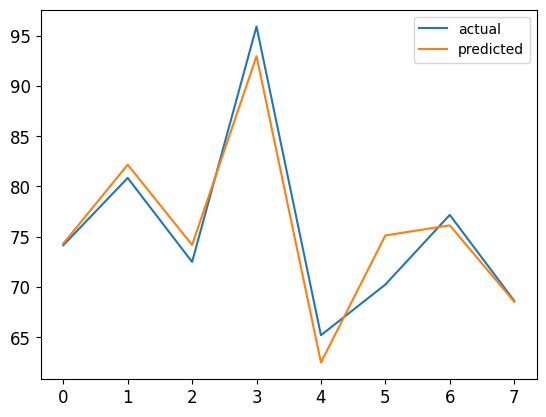

In [221]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with one layer

In [222]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=[9, 1]),
    keras.layers.Dense(1, activation=None)
])

In [223]:
model.compile(loss="mse", optimizer='Adam')

import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_x, train_target, epochs=100, callbacks=[call_back])

end_time = time.time()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.6988

1/1 [==============================] - 2s 2s/step - loss: 0.6988
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.6781

1/1 [==============================] - 0s 14ms/step - loss: 0.6781
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.6576

1/1 [==============================] - 0s 14ms/step - loss: 0.6576
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.6370

1/1 [==============================] - 0s 15ms/step - loss: 0.6370
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.6163

1/1 [==============================] - 0s 15ms/step - loss: 0.6163
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.5957

1/1 [==============================] - 0s 15ms/step - loss: 0.5957
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.5750

1/1 [==============================] - 0s 13ms/step - loss: 0.5750
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.5543

1/1 [==============================] - 0s 16ms/step - loss: 0.5543
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.5336

1/1 [==============================] - 0s 16ms/step - loss: 0.5336
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.5129

1/1 [==============================] - 0s 15ms/step - loss: 0.5129
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.4923

1/1 [==============================] - 0s 21ms/step - loss: 0.4923
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.4717

1/1 [==============================] - 0s 16ms/step - loss: 0.4717
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.4511

1/1 [==============================] - 0s 17ms/step - loss: 0.4511
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.4305

1/1 [==============================] - 0s 17ms/step - loss: 0.4305
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.4100

1/1 [==============================] - 0s 16ms/step - loss: 0.4100
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.3895

1/1 [==============================] - 0s 19ms/step - loss: 0.3895
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.3689

1/1 [==============================] - 0s 18ms/step - loss: 0.3689
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.3484

1/1 [==============================] - 0s 16ms/step - loss: 0.3484
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.3278

1/1 [==============================] - 0s 19ms/step - loss: 0.3278
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.3073

1/1 [==============================] - 0s 17ms/step - loss: 0.3073
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.2869

1/1 [==============================] - 0s 21ms/step - loss: 0.2869
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.2668

1/1 [==============================] - 0s 20ms/step - loss: 0.2668
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.2469

1/1 [==============================] - 0s 18ms/step - loss: 0.2469
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.2272

1/1 [==============================] - 0s 17ms/step - loss: 0.2272
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.2077

1/1 [==============================] - 0s 17ms/step - loss: 0.2077
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.1885

1/1 [==============================] - 0s 16ms/step - loss: 0.1885
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.1698

1/1 [==============================] - 0s 19ms/step - loss: 0.1698
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.1517

1/1 [==============================] - 0s 20ms/step - loss: 0.1517
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1345

1/1 [==============================] - 0s 23ms/step - loss: 0.1345
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1182

1/1 [==============================] - 0s 20ms/step - loss: 0.1182
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1031

1/1 [==============================] - 0s 19ms/step - loss: 0.1031
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.0893

1/1 [==============================] - 0s 22ms/step - loss: 0.0893
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.0770

1/1 [==============================] - 0s 16ms/step - loss: 0.0770
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.0664

1/1 [==============================] - 0s 19ms/step - loss: 0.0664
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.0575

1/1 [==============================] - 0s 16ms/step - loss: 0.0575
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0507

1/1 [==============================] - 0s 20ms/step - loss: 0.0507
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.0461

1/1 [==============================] - 0s 15ms/step - loss: 0.0461
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0439

1/1 [==============================] - 0s 17ms/step - loss: 0.0439
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0438

1/1 [==============================] - 0s 18ms/step - loss: 0.0438
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0456

1/1 [==============================] - 0s 22ms/step - loss: 0.0456
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0481

1/1 [==============================] - 0s 17ms/step - loss: 0.0481
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0504

1/1 [==============================] - 0s 24ms/step - loss: 0.0504
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0516

1/1 [==============================] - 0s 18ms/step - loss: 0.0516
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0512

1/1 [==============================] - 0s 17ms/step - loss: 0.0512
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0494

1/1 [==============================] - 0s 17ms/step - loss: 0.0494
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0465

1/1 [==============================] - 0s 16ms/step - loss: 0.0465
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0432

1/1 [==============================] - 0s 17ms/step - loss: 0.0432
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0398

1/1 [==============================] - 0s 17ms/step - loss: 0.0398
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0368

1/1 [==============================] - 0s 23ms/step - loss: 0.0368
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0342

1/1 [==============================] - 0s 18ms/step - loss: 0.0342
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 15ms/step - loss: 0.0321
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0305

1/1 [==============================] - 0s 21ms/step - loss: 0.0305
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0293

1/1 [==============================] - 0s 18ms/step - loss: 0.0293
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0285

1/1 [==============================] - 0s 15ms/step - loss: 0.0285
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0280

1/1 [==============================] - 0s 21ms/step - loss: 0.0280
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0278

1/1 [==============================] - 0s 15ms/step - loss: 0.0278
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0278

1/1 [==============================] - 0s 17ms/step - loss: 0.0278
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0280

1/1 [==============================] - 0s 14ms/step - loss: 0.0280
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0282

1/1 [==============================] - 0s 25ms/step - loss: 0.0282
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0283

1/1 [==============================] - 0s 13ms/step - loss: 0.0283
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0283

1/1 [==============================] - 0s 15ms/step - loss: 0.0283
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0280

1/1 [==============================] - 0s 19ms/step - loss: 0.0280
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0277

1/1 [==============================] - 0s 16ms/step - loss: 0.0277
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0274

1/1 [==============================] - 0s 16ms/step - loss: 0.0274
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0271

1/1 [==============================] - 0s 19ms/step - loss: 0.0271
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0268

1/1 [==============================] - 0s 16ms/step - loss: 0.0268
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0264

1/1 [==============================] - 0s 20ms/step - loss: 0.0264
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0261

1/1 [==============================] - 0s 15ms/step - loss: 0.0261
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0257

1/1 [==============================] - 0s 19ms/step - loss: 0.0257
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0253

1/1 [==============================] - 0s 15ms/step - loss: 0.0253
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0250

1/1 [==============================] - 0s 14ms/step - loss: 0.0250
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0248

1/1 [==============================] - 0s 18ms/step - loss: 0.0248
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0247

1/1 [==============================] - 0s 20ms/step - loss: 0.0247
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0246

1/1 [==============================] - 0s 14ms/step - loss: 0.0246
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0245

1/1 [==============================] - 0s 14ms/step - loss: 0.0245
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0243

1/1 [==============================] - 0s 18ms/step - loss: 0.0243
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0242

1/1 [==============================] - 0s 14ms/step - loss: 0.0242
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0240

1/1 [==============================] - 0s 16ms/step - loss: 0.0240
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0238

1/1 [==============================] - 0s 19ms/step - loss: 0.0238
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0237

1/1 [==============================] - 0s 16ms/step - loss: 0.0237
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0235

1/1 [==============================] - 0s 22ms/step - loss: 0.0235
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0233

1/1 [==============================] - 0s 15ms/step - loss: 0.0233
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0232

1/1 [==============================] - 0s 18ms/step - loss: 0.0232
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0230

1/1 [==============================] - 0s 17ms/step - loss: 0.0230
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0229

1/1 [==============================] - 0s 19ms/step - loss: 0.0229
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 0s 22ms/step - loss: 0.0227
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0226

1/1 [==============================] - 0s 15ms/step - loss: 0.0226
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0225

1/1 [==============================] - 0s 15ms/step - loss: 0.0225
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0224

1/1 [==============================] - 0s 22ms/step - loss: 0.0224
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0223

1/1 [==============================] - 0s 16ms/step - loss: 0.0223
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0223

1/1 [==============================] - 0s 14ms/step - loss: 0.0223
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0222

1/1 [==============================] - 0s 18ms/step - loss: 0.0222
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0221

1/1 [==============================] - 0s 21ms/step - loss: 0.0221
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0220

1/1 [==============================] - 0s 16ms/step - loss: 0.0220
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0219

1/1 [==============================] - 0s 21ms/step - loss: 0.0219
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0218

1/1 [==============================] - 0s 15ms/step - loss: 0.0218
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0217

1/1 [==============================] - 0s 16ms/step - loss: 0.0217
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0215

1/1 [==============================] - 0s 23ms/step - loss: 0.0215
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 13ms/step - loss: 0.0214
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0213

1/1 [==============================] - 0s 14ms/step - loss: 0.0213


### Predictions

In [224]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 194ms/step


In [225]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [226]:
mse_score = mean_squared_error(comparison['actual'], comparison['predicted'])

In [227]:
df_result = pd.DataFrame(
    {
        'model': ['LSTM'], 
        'time': [end_time - start_time],
        'mse': [mse_score]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

In [228]:
df_results

,model,time,mse
0,NN,2.250607,6.218680
1,Deep RNN,7.107786,5.711153
2,LSTM,4.126215,9.883094


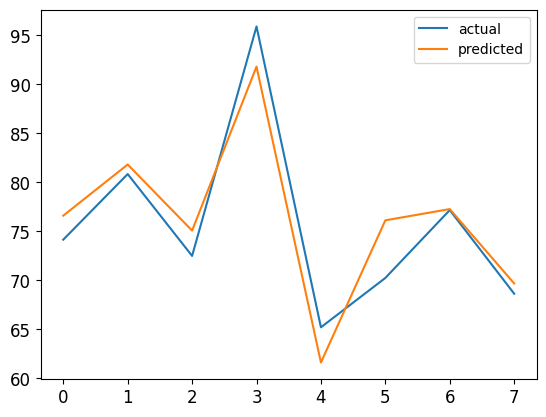

In [229]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [230]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [231]:
model.compile(loss="mse", optimizer='Adam')

import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_x, train_target, epochs=100, callbacks=[call_back])

end_time = time.time()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.9952

1/1 [==============================] - 4s 4s/step - loss: 0.9952
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.9330

1/1 [==============================] - 0s 27ms/step - loss: 0.9330
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.8723

1/1 [==============================] - 0s 30ms/step - loss: 0.8723
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.8129

1/1 [==============================] - 0s 33ms/step - loss: 0.8129
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.7549

1/1 [==============================] - 0s 29ms/step - loss: 0.7549
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.6982

1/1 [==============================] - 0s 31ms/step - loss: 0.6982
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.6428

1/1 [==============================] - 0s 29ms/step - loss: 0.6428
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.5886

1/1 [==============================] - 0s 29ms/step - loss: 0.5886
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.5357

1/1 [==============================] - 0s 31ms/step - loss: 0.5357
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.4843

1/1 [==============================] - 0s 33ms/step - loss: 0.4843
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.4344

1/1 [==============================] - 0s 46ms/step - loss: 0.4344
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.3866

1/1 [==============================] - 0s 27ms/step - loss: 0.3866
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.3411

1/1 [==============================] - 0s 35ms/step - loss: 0.3411
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.2985

1/1 [==============================] - 0s 31ms/step - loss: 0.2985
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.2596

1/1 [==============================] - 0s 23ms/step - loss: 0.2596
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.2251

1/1 [==============================] - 0s 34ms/step - loss: 0.2251
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.1957

1/1 [==============================] - 0s 32ms/step - loss: 0.1957
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.1722

1/1 [==============================] - 0s 27ms/step - loss: 0.1722
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.1549

1/1 [==============================] - 0s 26ms/step - loss: 0.1549
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.1435

1/1 [==============================] - 0s 33ms/step - loss: 0.1435
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.1371

1/1 [==============================] - 0s 30ms/step - loss: 0.1371
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.1339

1/1 [==============================] - 0s 26ms/step - loss: 0.1339
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.1322

1/1 [==============================] - 0s 26ms/step - loss: 0.1322
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.1306

1/1 [==============================] - 0s 27ms/step - loss: 0.1306
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.1282

1/1 [==============================] - 0s 26ms/step - loss: 0.1282
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.1251

1/1 [==============================] - 0s 31ms/step - loss: 0.1251
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.1215

1/1 [==============================] - 0s 28ms/step - loss: 0.1215
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.1179

1/1 [==============================] - 0s 28ms/step - loss: 0.1179
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1149

1/1 [==============================] - 0s 28ms/step - loss: 0.1149
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1128

1/1 [==============================] - 0s 29ms/step - loss: 0.1128
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1115

1/1 [==============================] - 0s 25ms/step - loss: 0.1115
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.1107

1/1 [==============================] - 0s 26ms/step - loss: 0.1107
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.1102

1/1 [==============================] - 0s 25ms/step - loss: 0.1102
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.1095

1/1 [==============================] - 0s 29ms/step - loss: 0.1095
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.1084

1/1 [==============================] - 0s 26ms/step - loss: 0.1084
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.1069

1/1 [==============================] - 0s 25ms/step - loss: 0.1069
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.1051

1/1 [==============================] - 0s 26ms/step - loss: 0.1051
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.1030

1/1 [==============================] - 0s 27ms/step - loss: 0.1030
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.1010

1/1 [==============================] - 0s 30ms/step - loss: 0.1010
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0990

1/1 [==============================] - 0s 24ms/step - loss: 0.0990
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0972

1/1 [==============================] - 0s 26ms/step - loss: 0.0972
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0956

1/1 [==============================] - 0s 29ms/step - loss: 0.0956
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0943

1/1 [==============================] - 0s 25ms/step - loss: 0.0943
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0931

1/1 [==============================] - 0s 29ms/step - loss: 0.0931
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0922

1/1 [==============================] - 0s 28ms/step - loss: 0.0922
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0914

1/1 [==============================] - 0s 28ms/step - loss: 0.0914
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0907

1/1 [==============================] - 0s 26ms/step - loss: 0.0907
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0901

1/1 [==============================] - 0s 30ms/step - loss: 0.0901
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0895

1/1 [==============================] - 0s 29ms/step - loss: 0.0895
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0890

1/1 [==============================] - 0s 25ms/step - loss: 0.0890
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0885

1/1 [==============================] - 0s 30ms/step - loss: 0.0885
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0880

1/1 [==============================] - 0s 40ms/step - loss: 0.0880
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0875

1/1 [==============================] - 0s 35ms/step - loss: 0.0875
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0869

1/1 [==============================] - 0s 36ms/step - loss: 0.0869
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0863

1/1 [==============================] - 0s 29ms/step - loss: 0.0863
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0856

1/1 [==============================] - 0s 28ms/step - loss: 0.0856
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0849

1/1 [==============================] - 0s 26ms/step - loss: 0.0849
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0842

1/1 [==============================] - 0s 37ms/step - loss: 0.0842
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0835

1/1 [==============================] - 0s 44ms/step - loss: 0.0835
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0828

1/1 [==============================] - 0s 29ms/step - loss: 0.0828
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0821

1/1 [==============================] - 0s 45ms/step - loss: 0.0821
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0815

1/1 [==============================] - 0s 34ms/step - loss: 0.0815
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0809

1/1 [==============================] - 0s 45ms/step - loss: 0.0809
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0804

1/1 [==============================] - 0s 32ms/step - loss: 0.0804
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0799

1/1 [==============================] - 0s 41ms/step - loss: 0.0799
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0795

1/1 [==============================] - 0s 42ms/step - loss: 0.0795
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0791

1/1 [==============================] - 0s 33ms/step - loss: 0.0791
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0786

1/1 [==============================] - 0s 30ms/step - loss: 0.0786
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0781

1/1 [==============================] - 0s 32ms/step - loss: 0.0781
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0776

1/1 [==============================] - 0s 29ms/step - loss: 0.0776
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0771

1/1 [==============================] - 0s 28ms/step - loss: 0.0771
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0766

1/1 [==============================] - 0s 33ms/step - loss: 0.0766
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0760

1/1 [==============================] - 0s 30ms/step - loss: 0.0760
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0755

1/1 [==============================] - 0s 40ms/step - loss: 0.0755
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0750

1/1 [==============================] - 0s 35ms/step - loss: 0.0750
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0744

1/1 [==============================] - 0s 34ms/step - loss: 0.0744
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0739

1/1 [==============================] - 0s 30ms/step - loss: 0.0739
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0734

1/1 [==============================] - 0s 38ms/step - loss: 0.0734
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0729

1/1 [==============================] - 0s 28ms/step - loss: 0.0729
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0723

1/1 [==============================] - 0s 25ms/step - loss: 0.0723
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0718

1/1 [==============================] - 0s 33ms/step - loss: 0.0718
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0713

1/1 [==============================] - 0s 41ms/step - loss: 0.0713
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0708

1/1 [==============================] - 0s 34ms/step - loss: 0.0708
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0702

1/1 [==============================] - 0s 32ms/step - loss: 0.0702
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0697

1/1 [==============================] - 0s 33ms/step - loss: 0.0697
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0691

1/1 [==============================] - 0s 30ms/step - loss: 0.0691
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0686

1/1 [==============================] - 0s 40ms/step - loss: 0.0686
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0680

1/1 [==============================] - 0s 34ms/step - loss: 0.0680
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0675

1/1 [==============================] - 0s 27ms/step - loss: 0.0675
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0669

1/1 [==============================] - 0s 26ms/step - loss: 0.0669
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0664

1/1 [==============================] - 0s 27ms/step - loss: 0.0664
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0658

1/1 [==============================] - 0s 30ms/step - loss: 0.0658
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0652

1/1 [==============================] - 0s 24ms/step - loss: 0.0652
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0647

1/1 [==============================] - 0s 36ms/step - loss: 0.0647
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0641

1/1 [==============================] - 0s 28ms/step - loss: 0.0641
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0635

1/1 [==============================] - 0s 27ms/step - loss: 0.0635
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0629

1/1 [==============================] - 0s 26ms/step - loss: 0.0629
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0623

1/1 [==============================] - 0s 27ms/step - loss: 0.0623
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0617

1/1 [==============================] - 0s 27ms/step - loss: 0.0617
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0611

1/1 [==============================] - 0s 24ms/step - loss: 0.0611


### Predictions

In [232]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 869ms/step


In [233]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [234]:
mse_score = mean_squared_error(comparison['actual'], comparison['predicted'])

In [235]:
df_result = pd.DataFrame(
    {
        'model': ['Deep LSTM'], 
        'time': [end_time - start_time],
        'mse': [mse_score]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

In [236]:
df_results

,model,time,mse
0,NN,2.250607,6.218680
1,Deep RNN,7.107786,5.711153
2,LSTM,4.126215,9.883094
3,Deep LSTM,7.841144,15.102559


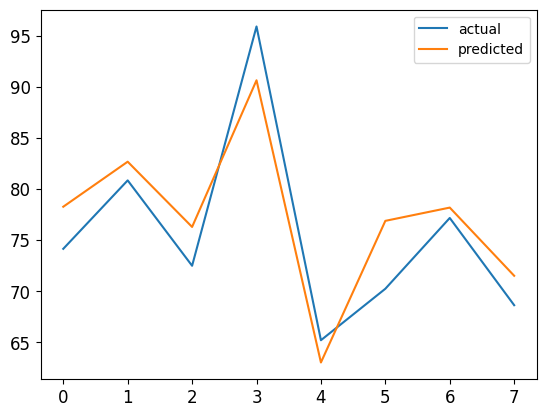

In [237]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [238]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [239]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='RMSprop')

import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_x, train_target, epochs=100, callbacks=[call_back])

end_time = time.time()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.0207

1/1 [==============================] - 4s 4s/step - loss: 1.0207
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.9028

1/1 [==============================] - 0s 20ms/step - loss: 0.9028
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.8123

1/1 [==============================] - 0s 29ms/step - loss: 0.8123
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.7476

1/1 [==============================] - 0s 22ms/step - loss: 0.7476
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.6924

1/1 [==============================] - 0s 24ms/step - loss: 0.6924
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.6418

1/1 [==============================] - 0s 30ms/step - loss: 0.6418
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.5958

1/1 [==============================] - 0s 33ms/step - loss: 0.5958
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.5545

1/1 [==============================] - 0s 27ms/step - loss: 0.5545
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.5161

1/1 [==============================] - 0s 26ms/step - loss: 0.5161
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.4800

1/1 [==============================] - 0s 22ms/step - loss: 0.4800
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.4455

1/1 [==============================] - 0s 24ms/step - loss: 0.4455
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.4120

1/1 [==============================] - 0s 22ms/step - loss: 0.4120
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.3805

1/1 [==============================] - 0s 27ms/step - loss: 0.3805
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.3512

1/1 [==============================] - 0s 25ms/step - loss: 0.3512
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.3243

1/1 [==============================] - 0s 24ms/step - loss: 0.3243
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.2998

1/1 [==============================] - 0s 22ms/step - loss: 0.2998
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.2775

1/1 [==============================] - 0s 22ms/step - loss: 0.2775
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.2576

1/1 [==============================] - 0s 23ms/step - loss: 0.2576
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.2398

1/1 [==============================] - 0s 35ms/step - loss: 0.2398
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.2239

1/1 [==============================] - 0s 25ms/step - loss: 0.2239
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.2095

1/1 [==============================] - 0s 26ms/step - loss: 0.2095
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.1964

1/1 [==============================] - 0s 28ms/step - loss: 0.1964
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.1843

1/1 [==============================] - 0s 29ms/step - loss: 0.1843
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.1729

1/1 [==============================] - 0s 28ms/step - loss: 0.1729
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.1622

1/1 [==============================] - 0s 27ms/step - loss: 0.1622
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.1520

1/1 [==============================] - 0s 27ms/step - loss: 0.1520
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.1422

1/1 [==============================] - 0s 25ms/step - loss: 0.1422
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.1329

1/1 [==============================] - 0s 30ms/step - loss: 0.1329
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1241

1/1 [==============================] - 0s 23ms/step - loss: 0.1241
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1156

1/1 [==============================] - 0s 22ms/step - loss: 0.1156
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1076

1/1 [==============================] - 0s 28ms/step - loss: 0.1076
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.1002

1/1 [==============================] - 0s 24ms/step - loss: 0.1002
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.0933

1/1 [==============================] - 0s 25ms/step - loss: 0.0933
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.0868

1/1 [==============================] - 0s 25ms/step - loss: 0.0868
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.0808

1/1 [==============================] - 0s 29ms/step - loss: 0.0808
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0754

1/1 [==============================] - 0s 23ms/step - loss: 0.0754
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.0705

1/1 [==============================] - 0s 25ms/step - loss: 0.0705
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0662

1/1 [==============================] - 0s 25ms/step - loss: 0.0662
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0623

1/1 [==============================] - 0s 22ms/step - loss: 0.0623
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0586

1/1 [==============================] - 0s 29ms/step - loss: 0.0586
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0553

1/1 [==============================] - 0s 35ms/step - loss: 0.0553
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0521

1/1 [==============================] - 0s 26ms/step - loss: 0.0521
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0489

1/1 [==============================] - 0s 28ms/step - loss: 0.0489
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0463

1/1 [==============================] - 0s 23ms/step - loss: 0.0463
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0436

1/1 [==============================] - 0s 25ms/step - loss: 0.0436
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0414

1/1 [==============================] - 0s 32ms/step - loss: 0.0414
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0395

1/1 [==============================] - 0s 32ms/step - loss: 0.0395
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0384

1/1 [==============================] - 0s 28ms/step - loss: 0.0384
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0372

1/1 [==============================] - 0s 26ms/step - loss: 0.0372
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0360

1/1 [==============================] - 0s 30ms/step - loss: 0.0360
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0344

1/1 [==============================] - 0s 28ms/step - loss: 0.0344
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0334

1/1 [==============================] - 0s 23ms/step - loss: 0.0334
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 24ms/step - loss: 0.0321
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0314

1/1 [==============================] - 0s 34ms/step - loss: 0.0314
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0304

1/1 [==============================] - 0s 26ms/step - loss: 0.0304
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0297

1/1 [==============================] - 0s 24ms/step - loss: 0.0297
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0290

1/1 [==============================] - 0s 33ms/step - loss: 0.0290
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0286

1/1 [==============================] - 0s 27ms/step - loss: 0.0286
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0282

1/1 [==============================] - 0s 27ms/step - loss: 0.0282
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0277

1/1 [==============================] - 0s 30ms/step - loss: 0.0277
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0274

1/1 [==============================] - 0s 28ms/step - loss: 0.0274
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0269

1/1 [==============================] - 0s 27ms/step - loss: 0.0269
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0265

1/1 [==============================] - 0s 24ms/step - loss: 0.0265
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0258

1/1 [==============================] - 0s 27ms/step - loss: 0.0258
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0251

1/1 [==============================] - 0s 27ms/step - loss: 0.0251
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0245

1/1 [==============================] - 0s 27ms/step - loss: 0.0245
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0239

1/1 [==============================] - 0s 27ms/step - loss: 0.0239
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0234

1/1 [==============================] - 0s 27ms/step - loss: 0.0234
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0230

1/1 [==============================] - 0s 24ms/step - loss: 0.0230
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 0s 31ms/step - loss: 0.0227
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0225

1/1 [==============================] - 0s 33ms/step - loss: 0.0225
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0223

1/1 [==============================] - 0s 28ms/step - loss: 0.0223
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0221

1/1 [==============================] - 0s 30ms/step - loss: 0.0221
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0219

1/1 [==============================] - 0s 31ms/step - loss: 0.0219
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0216

1/1 [==============================] - 0s 23ms/step - loss: 0.0216
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 32ms/step - loss: 0.0214
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0211

1/1 [==============================] - 0s 25ms/step - loss: 0.0211
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0207

1/1 [==============================] - 0s 31ms/step - loss: 0.0207
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0203

1/1 [==============================] - 0s 25ms/step - loss: 0.0203
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0201

1/1 [==============================] - 0s 30ms/step - loss: 0.0201
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0197

1/1 [==============================] - 0s 28ms/step - loss: 0.0197
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0196

1/1 [==============================] - 0s 25ms/step - loss: 0.0196
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0194

1/1 [==============================] - 0s 26ms/step - loss: 0.0194
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0193

1/1 [==============================] - 0s 30ms/step - loss: 0.0193
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0192

1/1 [==============================] - 0s 30ms/step - loss: 0.0192
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0190

1/1 [==============================] - 0s 25ms/step - loss: 0.0190
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0188

1/1 [==============================] - 0s 26ms/step - loss: 0.0188
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0187

1/1 [==============================] - 0s 25ms/step - loss: 0.0187
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0185

1/1 [==============================] - 0s 24ms/step - loss: 0.0185
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0183

1/1 [==============================] - 0s 26ms/step - loss: 0.0183
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0181

1/1 [==============================] - 0s 26ms/step - loss: 0.0181
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0179

1/1 [==============================] - 0s 25ms/step - loss: 0.0179
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 25ms/step - loss: 0.0177
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0177

1/1 [==============================] - 0s 24ms/step - loss: 0.0177
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0176

1/1 [==============================] - 0s 27ms/step - loss: 0.0176
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0173

1/1 [==============================] - 0s 27ms/step - loss: 0.0173
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0172

1/1 [==============================] - 0s 28ms/step - loss: 0.0172
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0170

1/1 [==============================] - 0s 26ms/step - loss: 0.0170
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0169

1/1 [==============================] - 0s 25ms/step - loss: 0.0169


### Predictions

In [240]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 375ms/step


In [241]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [242]:
mse_score = mean_squared_error(comparison['actual'], comparison['predicted'])

In [243]:
df_result = pd.DataFrame(
    {
        'model': ['Deep GRU'], 
        'time': [end_time - start_time],
        'mse': [mse_score]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

In [244]:
df_results

,model,time,mse
0,NN,2.250607,6.218680
1,Deep RNN,7.107786,5.711153
2,LSTM,4.126215,9.883094
3,Deep LSTM,7.841144,15.102559
4,Deep GRU,6.892589,8.718265


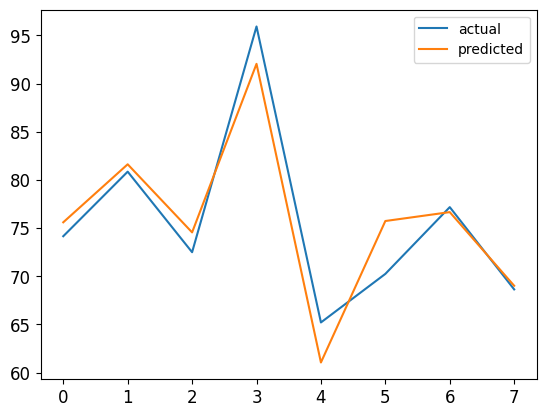

In [245]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [246]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [247]:
model.compile(loss="mse", optimizer='Adam')

import time
start_time = time.time()

call_back = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(train_x, train_target, epochs=100, callbacks=[call_back])

end_time = time.time()

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.0549

1/1 [==============================] - 4s 4s/step - loss: 1.0549
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 1.0137

1/1 [==============================] - 0s 19ms/step - loss: 1.0137
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 0.9751

1/1 [==============================] - 0s 22ms/step - loss: 0.9751
Epoch 4/100
1/1 [==============================] - ETA: 0s - loss: 0.9389

1/1 [==============================] - 0s 21ms/step - loss: 0.9389
Epoch 5/100
1/1 [==============================] - ETA: 0s - loss: 0.9027

1/1 [==============================] - 0s 20ms/step - loss: 0.9027
Epoch 6/100
1/1 [==============================] - ETA: 0s - loss: 0.8666

1/1 [==============================] - 0s 19ms/step - loss: 0.8666
Epoch 7/100
1/1 [==============================] - ETA: 0s - loss: 0.8302

1/1 [==============================] - 0s 20ms/step - loss: 0.8302
Epoch 8/100
1/1 [==============================] - ETA: 0s - loss: 0.7932

1/1 [==============================] - 0s 23ms/step - loss: 0.7932
Epoch 9/100
1/1 [==============================] - ETA: 0s - loss: 0.7563

1/1 [==============================] - 0s 33ms/step - loss: 0.7563
Epoch 10/100
1/1 [==============================] - ETA: 0s - loss: 0.7196

1/1 [==============================] - 0s 19ms/step - loss: 0.7196
Epoch 11/100
1/1 [==============================] - ETA: 0s - loss: 0.6833

1/1 [==============================] - 0s 21ms/step - loss: 0.6833
Epoch 12/100
1/1 [==============================] - ETA: 0s - loss: 0.6475

1/1 [==============================] - 0s 22ms/step - loss: 0.6475
Epoch 13/100
1/1 [==============================] - ETA: 0s - loss: 0.6117

1/1 [==============================] - 0s 23ms/step - loss: 0.6117
Epoch 14/100
1/1 [==============================] - ETA: 0s - loss: 0.5756

1/1 [==============================] - 0s 19ms/step - loss: 0.5756
Epoch 15/100
1/1 [==============================] - ETA: 0s - loss: 0.5392

1/1 [==============================] - 0s 21ms/step - loss: 0.5392
Epoch 16/100
1/1 [==============================] - ETA: 0s - loss: 0.5029

1/1 [==============================] - 0s 20ms/step - loss: 0.5029
Epoch 17/100
1/1 [==============================] - ETA: 0s - loss: 0.4671

1/1 [==============================] - 0s 24ms/step - loss: 0.4671
Epoch 18/100
1/1 [==============================] - ETA: 0s - loss: 0.4316

1/1 [==============================] - 0s 26ms/step - loss: 0.4316
Epoch 19/100
1/1 [==============================] - ETA: 0s - loss: 0.3973

1/1 [==============================] - 0s 21ms/step - loss: 0.3973
Epoch 20/100
1/1 [==============================] - ETA: 0s - loss: 0.3636

1/1 [==============================] - 0s 21ms/step - loss: 0.3636
Epoch 21/100
1/1 [==============================] - ETA: 0s - loss: 0.3311

1/1 [==============================] - 0s 22ms/step - loss: 0.3311
Epoch 22/100
1/1 [==============================] - ETA: 0s - loss: 0.3006

1/1 [==============================] - 0s 20ms/step - loss: 0.3006
Epoch 23/100
1/1 [==============================] - ETA: 0s - loss: 0.2725

1/1 [==============================] - 0s 24ms/step - loss: 0.2725
Epoch 24/100
1/1 [==============================] - ETA: 0s - loss: 0.2471

1/1 [==============================] - 0s 20ms/step - loss: 0.2471
Epoch 25/100
1/1 [==============================] - ETA: 0s - loss: 0.2249

1/1 [==============================] - 0s 20ms/step - loss: 0.2249
Epoch 26/100
1/1 [==============================] - ETA: 0s - loss: 0.2063

1/1 [==============================] - 0s 21ms/step - loss: 0.2063
Epoch 27/100
1/1 [==============================] - ETA: 0s - loss: 0.1914

1/1 [==============================] - 0s 24ms/step - loss: 0.1914
Epoch 28/100
1/1 [==============================] - ETA: 0s - loss: 0.1799

1/1 [==============================] - 0s 29ms/step - loss: 0.1799
Epoch 29/100
1/1 [==============================] - ETA: 0s - loss: 0.1711

1/1 [==============================] - 0s 29ms/step - loss: 0.1711
Epoch 30/100
1/1 [==============================] - ETA: 0s - loss: 0.1637

1/1 [==============================] - 0s 25ms/step - loss: 0.1637
Epoch 31/100
1/1 [==============================] - ETA: 0s - loss: 0.1561

1/1 [==============================] - 0s 21ms/step - loss: 0.1561
Epoch 32/100
1/1 [==============================] - ETA: 0s - loss: 0.1471

1/1 [==============================] - 0s 21ms/step - loss: 0.1471
Epoch 33/100
1/1 [==============================] - ETA: 0s - loss: 0.1362

1/1 [==============================] - 0s 23ms/step - loss: 0.1362
Epoch 34/100
1/1 [==============================] - ETA: 0s - loss: 0.1233

1/1 [==============================] - 0s 21ms/step - loss: 0.1233
Epoch 35/100
1/1 [==============================] - ETA: 0s - loss: 0.1093

1/1 [==============================] - 0s 25ms/step - loss: 0.1093
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0949

1/1 [==============================] - 0s 24ms/step - loss: 0.0949
Epoch 37/100
1/1 [==============================] - ETA: 0s - loss: 0.0812

1/1 [==============================] - 0s 32ms/step - loss: 0.0812
Epoch 38/100
1/1 [==============================] - ETA: 0s - loss: 0.0690

1/1 [==============================] - 0s 25ms/step - loss: 0.0690
Epoch 39/100
1/1 [==============================] - ETA: 0s - loss: 0.0593

1/1 [==============================] - 0s 25ms/step - loss: 0.0593
Epoch 40/100
1/1 [==============================] - ETA: 0s - loss: 0.0522

1/1 [==============================] - 0s 26ms/step - loss: 0.0522
Epoch 41/100
1/1 [==============================] - ETA: 0s - loss: 0.0482

1/1 [==============================] - 0s 23ms/step - loss: 0.0482
Epoch 42/100
1/1 [==============================] - ETA: 0s - loss: 0.0471

1/1 [==============================] - 0s 24ms/step - loss: 0.0471
Epoch 43/100
1/1 [==============================] - ETA: 0s - loss: 0.0483

1/1 [==============================] - 0s 26ms/step - loss: 0.0483
Epoch 44/100
1/1 [==============================] - ETA: 0s - loss: 0.0513

1/1 [==============================] - 0s 30ms/step - loss: 0.0513
Epoch 45/100
1/1 [==============================] - ETA: 0s - loss: 0.0550

1/1 [==============================] - 0s 27ms/step - loss: 0.0550
Epoch 46/100
1/1 [==============================] - ETA: 0s - loss: 0.0584

1/1 [==============================] - 0s 20ms/step - loss: 0.0584
Epoch 47/100
1/1 [==============================] - ETA: 0s - loss: 0.0606

1/1 [==============================] - 0s 21ms/step - loss: 0.0606
Epoch 48/100
1/1 [==============================] - ETA: 0s - loss: 0.0613

1/1 [==============================] - 0s 21ms/step - loss: 0.0613
Epoch 49/100
1/1 [==============================] - ETA: 0s - loss: 0.0602

1/1 [==============================] - 0s 27ms/step - loss: 0.0602
Epoch 50/100
1/1 [==============================] - ETA: 0s - loss: 0.0578

1/1 [==============================] - 0s 26ms/step - loss: 0.0578
Epoch 51/100
1/1 [==============================] - ETA: 0s - loss: 0.0544

1/1 [==============================] - 0s 24ms/step - loss: 0.0544
Epoch 52/100
1/1 [==============================] - ETA: 0s - loss: 0.0506

1/1 [==============================] - 0s 31ms/step - loss: 0.0506
Epoch 53/100
1/1 [==============================] - ETA: 0s - loss: 0.0470

1/1 [==============================] - 0s 26ms/step - loss: 0.0470
Epoch 54/100
1/1 [==============================] - ETA: 0s - loss: 0.0439

1/1 [==============================] - 0s 22ms/step - loss: 0.0439
Epoch 55/100
1/1 [==============================] - ETA: 0s - loss: 0.0414

1/1 [==============================] - 0s 22ms/step - loss: 0.0414
Epoch 56/100
1/1 [==============================] - ETA: 0s - loss: 0.0396

1/1 [==============================] - 0s 22ms/step - loss: 0.0396
Epoch 57/100
1/1 [==============================] - ETA: 0s - loss: 0.0385

1/1 [==============================] - 0s 25ms/step - loss: 0.0385
Epoch 58/100
1/1 [==============================] - ETA: 0s - loss: 0.0380

1/1 [==============================] - 0s 23ms/step - loss: 0.0380
Epoch 59/100
1/1 [==============================] - ETA: 0s - loss: 0.0379

1/1 [==============================] - 0s 22ms/step - loss: 0.0379
Epoch 60/100
1/1 [==============================] - ETA: 0s - loss: 0.0380

1/1 [==============================] - 0s 27ms/step - loss: 0.0380
Epoch 61/100
1/1 [==============================] - ETA: 0s - loss: 0.0382

1/1 [==============================] - 0s 21ms/step - loss: 0.0382
Epoch 62/100
1/1 [==============================] - ETA: 0s - loss: 0.0384

1/1 [==============================] - 0s 22ms/step - loss: 0.0384
Epoch 63/100
1/1 [==============================] - ETA: 0s - loss: 0.0384

1/1 [==============================] - 0s 25ms/step - loss: 0.0384
Epoch 64/100
1/1 [==============================] - ETA: 0s - loss: 0.0382

1/1 [==============================] - 0s 28ms/step - loss: 0.0382
Epoch 65/100
1/1 [==============================] - ETA: 0s - loss: 0.0377

1/1 [==============================] - 0s 23ms/step - loss: 0.0377
Epoch 66/100
1/1 [==============================] - ETA: 0s - loss: 0.0370

1/1 [==============================] - 0s 29ms/step - loss: 0.0370
Epoch 67/100
1/1 [==============================] - ETA: 0s - loss: 0.0360

1/1 [==============================] - 0s 29ms/step - loss: 0.0360
Epoch 68/100
1/1 [==============================] - ETA: 0s - loss: 0.0350

1/1 [==============================] - 0s 27ms/step - loss: 0.0350
Epoch 69/100
1/1 [==============================] - ETA: 0s - loss: 0.0340

1/1 [==============================] - 0s 26ms/step - loss: 0.0340
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0330

1/1 [==============================] - 0s 30ms/step - loss: 0.0330
Epoch 71/100
1/1 [==============================] - ETA: 0s - loss: 0.0321

1/1 [==============================] - 0s 30ms/step - loss: 0.0321
Epoch 72/100
1/1 [==============================] - ETA: 0s - loss: 0.0313

1/1 [==============================] - 0s 31ms/step - loss: 0.0313
Epoch 73/100
1/1 [==============================] - ETA: 0s - loss: 0.0307

1/1 [==============================] - 0s 33ms/step - loss: 0.0307
Epoch 74/100
1/1 [==============================] - ETA: 0s - loss: 0.0303

1/1 [==============================] - 0s 20ms/step - loss: 0.0303
Epoch 75/100
1/1 [==============================] - ETA: 0s - loss: 0.0300

1/1 [==============================] - 0s 25ms/step - loss: 0.0300
Epoch 76/100
1/1 [==============================] - ETA: 0s - loss: 0.0298

1/1 [==============================] - 0s 21ms/step - loss: 0.0298
Epoch 77/100
1/1 [==============================] - ETA: 0s - loss: 0.0296

1/1 [==============================] - 0s 23ms/step - loss: 0.0296
Epoch 78/100
1/1 [==============================] - ETA: 0s - loss: 0.0293

1/1 [==============================] - 0s 34ms/step - loss: 0.0293
Epoch 79/100
1/1 [==============================] - ETA: 0s - loss: 0.0290

1/1 [==============================] - 0s 29ms/step - loss: 0.0290
Epoch 80/100
1/1 [==============================] - ETA: 0s - loss: 0.0286

1/1 [==============================] - 0s 28ms/step - loss: 0.0286
Epoch 81/100
1/1 [==============================] - ETA: 0s - loss: 0.0282

1/1 [==============================] - 0s 30ms/step - loss: 0.0282
Epoch 82/100
1/1 [==============================] - ETA: 0s - loss: 0.0277

1/1 [==============================] - 0s 25ms/step - loss: 0.0277
Epoch 83/100
1/1 [==============================] - ETA: 0s - loss: 0.0272

1/1 [==============================] - 0s 25ms/step - loss: 0.0272
Epoch 84/100
1/1 [==============================] - ETA: 0s - loss: 0.0267

1/1 [==============================] - 0s 27ms/step - loss: 0.0267
Epoch 85/100
1/1 [==============================] - ETA: 0s - loss: 0.0262

1/1 [==============================] - 0s 24ms/step - loss: 0.0262
Epoch 86/100
1/1 [==============================] - ETA: 0s - loss: 0.0257

1/1 [==============================] - 0s 29ms/step - loss: 0.0257
Epoch 87/100
1/1 [==============================] - ETA: 0s - loss: 0.0253

1/1 [==============================] - 0s 27ms/step - loss: 0.0253
Epoch 88/100
1/1 [==============================] - ETA: 0s - loss: 0.0249

1/1 [==============================] - 0s 24ms/step - loss: 0.0249
Epoch 89/100
1/1 [==============================] - ETA: 0s - loss: 0.0246

1/1 [==============================] - 0s 31ms/step - loss: 0.0246
Epoch 90/100
1/1 [==============================] - ETA: 0s - loss: 0.0242

1/1 [==============================] - 0s 32ms/step - loss: 0.0242
Epoch 91/100
1/1 [==============================] - ETA: 0s - loss: 0.0238

1/1 [==============================] - 0s 33ms/step - loss: 0.0238
Epoch 92/100
1/1 [==============================] - ETA: 0s - loss: 0.0235

1/1 [==============================] - 0s 26ms/step - loss: 0.0235
Epoch 93/100
1/1 [==============================] - ETA: 0s - loss: 0.0231

1/1 [==============================] - 0s 28ms/step - loss: 0.0231
Epoch 94/100
1/1 [==============================] - ETA: 0s - loss: 0.0227

1/1 [==============================] - 0s 25ms/step - loss: 0.0227
Epoch 95/100
1/1 [==============================] - ETA: 0s - loss: 0.0222

1/1 [==============================] - 0s 31ms/step - loss: 0.0222
Epoch 96/100
1/1 [==============================] - ETA: 0s - loss: 0.0218

1/1 [==============================] - 0s 26ms/step - loss: 0.0218
Epoch 97/100
1/1 [==============================] - ETA: 0s - loss: 0.0214

1/1 [==============================] - 0s 25ms/step - loss: 0.0214
Epoch 98/100
1/1 [==============================] - ETA: 0s - loss: 0.0209

1/1 [==============================] - 0s 26ms/step - loss: 0.0209
Epoch 99/100
1/1 [==============================] - ETA: 0s - loss: 0.0205

1/1 [==============================] - 0s 25ms/step - loss: 0.0205
Epoch 100/100
1/1 [==============================] - ETA: 0s - loss: 0.0201

1/1 [==============================] - 0s 30ms/step - loss: 0.0201


### Predictions

In [248]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 379ms/step


In [249]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [250]:
mse_score = mean_squared_error(comparison['actual'], comparison['predicted'])

In [251]:
df_result = pd.DataFrame(
    {
        'model': ['Conv1D'], 
        'time': [end_time - start_time],
        'mse': [mse_score]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

In [252]:
df_results

,model,time,mse
0,NN,2.250607,6.218680
1,Deep RNN,7.107786,5.711153
2,LSTM,4.126215,9.883094
3,Deep LSTM,7.841144,15.102559
4,Deep GRU,6.892589,8.718265
5,Conv1D,7.234703,7.596983


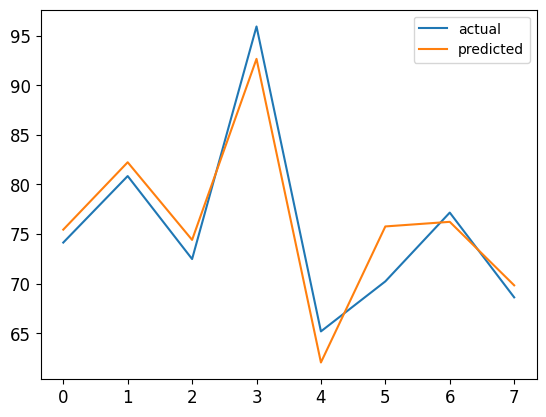

In [253]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

#SUMMARY OF RESULTS

In [254]:
df_results.sort_values(by=['mse'], ascending=True)

,model,time,mse
1,Deep RNN,7.107786,5.711153
0,NN,2.250607,6.218680
5,Conv1D,7.234703,7.596983
4,Deep GRU,6.892589,8.718265
2,LSTM,4.126215,9.883094
3,Deep LSTM,7.841144,15.102559


#Conclusion:

The estimator used to evaluate the regression model is the MSE (Mean Squared Error) or MSD (Mean Squared Deviation), which is based on the euclidean distance. The lower MSE value indicates the better accuracy of the model's prediction.

In this case, we are trying to predict the 'Close value' of Oracle Corporation's stock exchange value for the 10th day based of 9 previous days. The lower the mse, the better the prediction of the stock market value of ORCL based on the close value of 9 previous days.

Results of the 6 different algorthms used on model indicate that the mse value is least for Deep Neural Network with a value of 5.7, making it the best predictor. Closely followed by a regular neural network with a significanly low run time. The highest MSE value of 15.1 was observed for Deep LSTM. The runtime for all the deep networks is around 7 seconds.

